In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import io
from scipy.stats import linregress
import scipy 
import matplotlib
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures

In [52]:
#Importing datasets
crime_file = "Crimes_MASTER_2018.csv"
crime_df_18 = pd.read_csv(crime_file)
crime_df_18.head()
crime_file_17 = "Crimes_MASTER_2017.csv"
crime_df_17 = pd.read_csv(crime_file_17)
weather_17 = "Weather 2017.csv"
weather_18 = "Weather 2018.csv"
weather_17 = pd.read_csv(weather_17)
weather_18 = pd.read_csv(weather_18)
weather_18.head()


,dt,dt_iso,Date,city_id,city_name,lat,lon,temp,temp_min,temp_max,...,rain_today,snow_1h,snow_3h,snow_24h,snow_today,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1514764800,2018-01-01 00:00:00 +0000 UTC,2018-01-01 00:00:00,4887398,NaN,NaN,NaN,260.549984,258.15,263.15,...,NaN,NaN,NaN,NaN,NaN,75,803,Clouds,broken clouds,04n
1,1514768400,2018-01-01 01:00:00 +0000 UTC,2018-01-01 01:00:00,4887398,NaN,NaN,NaN,259.750000,257.15,262.15,...,NaN,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n
2,1514772000,2018-01-01 02:00:00 +0000 UTC,2018-01-01 02:00:00,4887398,NaN,NaN,NaN,258.750000,256.15,261.15,...,NaN,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03n
3,1514775600,2018-01-01 03:00:00 +0000 UTC,2018-01-01 03:00:00,4887398,NaN,NaN,NaN,256.850000,254.15,260.15,...,NaN,NaN,NaN,NaN,NaN,1,800,Clear,sky is clear,01n
4,1514779200,2018-01-01 04:00:00 +0000 UTC,2018-01-01 04:00:00,4887398,NaN,NaN,NaN,256.120000,253.15,259.15,...,NaN,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n


In [53]:
#Pulling out date and year from the datetime column into own column
weather_17['Date '] = pd.to_datetime(weather_17['Date '])
weather_17['Month'] = pd.DatetimeIndex(weather_17['Date ']).month
weather_17['Year'] = pd.DatetimeIndex(weather_17['Date ']).year
weather_17["Month"]
weather_17.head()
#Removing columns not neccesary 
weather_17_2 = weather_17[['Date ', 'temp', 'temp_min', 'temp_max', 'weather_description', 'Month', 'Year']].copy()
#Convert tempurature from Kelvin to Fahrenheit 
def f(x):
    x = 1.8*(x-273) + 32
    return float(x)
weather_17_2["f_temp"] = weather_17_2["temp"].apply(f)     
weather_17_2
weather_17_2["f_temp_min"] = weather_17_2["temp_min"].apply(f)
weather_17_2["f_temp_max"] = weather_17_2["temp_max"].apply(f)
#New dataframe                           
df_2017 = weather_17_2[['Date ', 'f_temp', 'f_temp_min', 'f_temp_max', 'weather_description', 'Month', 'Year']].copy()
df_2017.head()

,Date,f_temp,f_temp_min,f_temp_max,weather_description,Month,Year
0,2017-01-01 00:00:00,33.908,32.27,35.87,overcast clouds,1,2017
1,2017-01-01 01:00:00,31.892,28.67,34.07,scattered clouds,1,2017
2,2017-01-01 02:00:00,30.452,28.67,32.27,sky is clear,1,2017
3,2017-01-01 03:00:00,28.346,26.87,30.47,sky is clear,1,2017
4,2017-01-01 04:00:00,26.852,25.07,28.67,sky is clear,1,2017


In [54]:
#Weather 2018 pull out date and year from datetime column into own column
weather_18['Date '] = pd.to_datetime(weather_18['Date '])
weather_18['Month'] = pd.DatetimeIndex(weather_18['Date ']).month
weather_18['Year'] = pd.DatetimeIndex(weather_18['Date ']).year
weather_18["Month"]
#Remove columns and covert Kelvin temperatures to Fahrenheit 
weather_18_2 = weather_18[['Date ', 'temp', 'temp_min', 'temp_max', 'weather_description', 'Month', 'Year']].copy()
weather_18_2["f_temp"] = weather_18_2["temp"].apply(f)     
weather_18_2["f_temp_min"] = weather_18_2["temp_min"].apply(f)
weather_18_2["f_temp_max"] = weather_18_2["temp_max"].apply(f)
#New dataframe with fahrenheit temperatures                           
df_2018 = weather_18_2[['Date ', 'f_temp', 'f_temp_min', 'f_temp_max', 'weather_description', 'Month','Year']].copy()
df_2018.head()

,Date,f_temp,f_temp_min,f_temp_max,weather_description,Month,Year
0,2018-01-01 00:00:00,9.589972,5.27,14.27,broken clouds,1,2018
1,2018-01-01 01:00:00,8.150000,3.47,12.47,sky is clear,1,2018
2,2018-01-01 02:00:00,6.350000,1.67,10.67,scattered clouds,1,2018
3,2018-01-01 03:00:00,2.930000,-1.93,8.87,sky is clear,1,2018
4,2018-01-01 04:00:00,1.616000,-3.73,7.07,few clouds,1,2018


In [55]:
weather_merge = pd.merge(df_2017, df_2018, on="Year", how="outer", suffixes=( 2017, 2018) )
#weather_merge.info()
weather_merge


,Date 2017,f_temp2017,f_temp_min2017,f_temp_max2017,weather_description2017,Month2017,Year,Date 2018,f_temp2018,f_temp_min2018,f_temp_max2018,weather_description2018,Month2018
0,2017-01-01 00:00:00,33.908000,32.27,35.87,overcast clouds,1,2017,NaT,NaN,NaN,NaN,NaN,NaN
1,2017-01-01 01:00:00,31.892000,28.67,34.07,scattered clouds,1,2017,NaT,NaN,NaN,NaN,NaN,NaN
2,2017-01-01 02:00:00,30.452000,28.67,32.27,sky is clear,1,2017,NaT,NaN,NaN,NaN,NaN,NaN
3,2017-01-01 03:00:00,28.346000,26.87,30.47,sky is clear,1,2017,NaT,NaN,NaN,NaN,NaN,NaN
4,2017-01-01 04:00:00,26.852000,25.07,28.67,sky is clear,1,2017,NaT,NaN,NaN,NaN,NaN,NaN
5,2017-01-01 05:00:00,26.672000,25.07,28.67,sky is clear,1,2017,NaT,NaN,NaN,NaN,NaN,NaN
6,2017-01-01 06:00:00,25.412000,21.47,28.67,sky is clear,1,2017,NaT,NaN,NaN,NaN,NaN,NaN
7,2017-01-01 07:00:00,23.612000,19.67,26.87,sky is clear,1,2017,NaT,NaN,NaN,NaN,NaN,NaN
8,2017-01-01 08:00:00,22.874000,19.67,25.07,mist,1,2017,NaT,NaN,NaN,NaN,NaN,NaN
9,2017-01-01 09:00:00,21.470000,19.67,25.07,sky is clear,1,2017,NaT,NaN,NaN,NaN,NaN,NaN


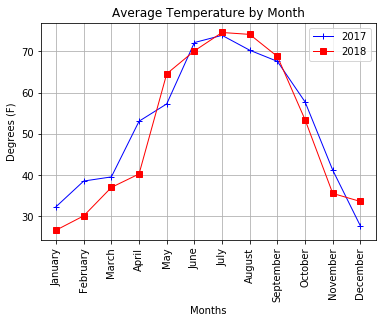

In [56]:
#Group by 2017 df
group_2017 = df_2017.groupby(['Month'])
avg_temp_2017 = group_2017["f_temp"].mean()
avg_temp_2017.to_frame()
avg_temp_2017
x_axis = np.arange(1,13,1)
labels = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October" ,"November", "December"]
y_axis_17 = [32.34, 38.56, 39.57, 53.07, 57.27, 72.15, 73.90, 70.29, 67.59, 57.76, 41.21, 27.67]

#Group 2018
group_2018 = df_2018.groupby(['Month'])
avg_temp_2018 = group_2018["f_temp"].mean()
avg_temp_2018.to_frame()
y_axis_18 = [26.65, 30.12, 37.02, 40.28, 64.57, 70.13, 74.59, 74.13, 68.77, 53.43, 35.56, 33.61]

#Avg Temp by month line graph 
weath_17, = plt.plot(x_axis, y_axis_17, marker="+",color="blue", linewidth=1, label="2017")
weath_18, = plt.plot(x_axis, y_axis_18, marker="s", color="Red", linewidth=1, label="2018")
plt.xticks(x_axis, labels, rotation='vertical')
#plt.legend(handles=[Avg_TEMP_17, Avg_TEMP_18], loc="best")
plt.title("Average Temperature by Month")
plt.xlabel("Months")
plt.ylabel("Degrees (F)")
plt.legend(handles=[weath_17, weath_18], loc="best")
plt.savefig("Average Temp by Month4.png" , bbox_inches = "tight")

plt.grid()
plt.show()

#plt.savefig("Average Temp by Month2.png")


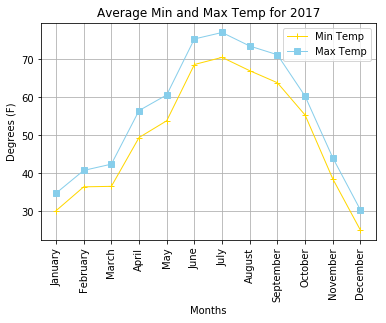

In [57]:
#Min and max for 2017
min_17 = group_2017["f_temp_min"].mean()
max_17 = group_2017["f_temp_max"].mean()

min_temp_17, = plt.plot(x_axis, min_17, marker="+",color="gold", linewidth=1, label="Min Temp" )
max_temp_17, = plt.plot(x_axis, max_17, marker="s", color="skyblue", linewidth=1, label="Max Temp")
plt.xticks(x_axis, labels, rotation='vertical')
plt.title("Average Min and Max Temp for 2017")
plt.xlabel("Months")
plt.ylabel("Degrees (F)")
plt.legend(handles=[min_temp_17, max_temp_17], loc="best")

plt.grid()
plt.savefig("Max_Min_174.png",bbox_inches = "tight")
plt.show()
#plt.savefig("Max_Min_172.png")

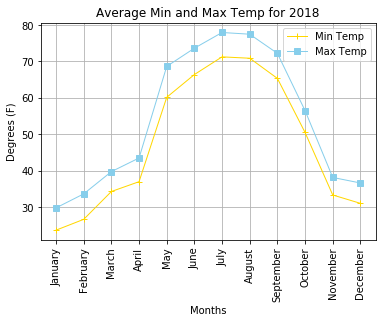

In [58]:
#Min and max for 2018
min_18 = group_2018["f_temp_min"].mean()
max_18 = group_2018["f_temp_max"].mean()

min_temp_18, = plt.plot(x_axis, min_18, marker="+",color="gold", linewidth=1, label="Min Temp" )
max_temp_18, = plt.plot(x_axis, max_18, marker="s", color="skyblue", linewidth=1, label="Max Temp")
plt.xticks(x_axis, labels, rotation='vertical')
plt.title("Average Min and Max Temp for 2018")
plt.xlabel("Months")
plt.ylabel("Degrees (F)")
plt.legend(handles=[min_temp_18, max_temp_18], loc="best")

plt.grid()
plt.savefig("Max_Min_183.png" , bbox_inches = "tight")
plt.show()


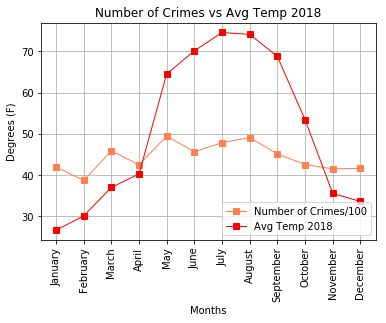

In [60]:
#Number of crimes per month 
crime_df_18
crime_df_18['Month'] = pd.DatetimeIndex(crime_df_18['Date']).month
crime_group_18 = crime_df_18.groupby(['Month'])
crime_count = crime_group_18["Primary Type"].count()
crime_count
y_axis_crime = [(4194/100), (3871/100), (4589/100), (4251/100), (4948/100), (4564/100), (4788/100), (4910/100), (4514/100), (4256/100), (4152/100), (4164/100)]

crime_data, = plt.plot(x_axis, y_axis_crime, marker="s", color="coral", linewidth=1, label = "Number of Crimes/100")
weath_18, = plt.plot(x_axis, y_axis_18, marker="s", color="Red", linewidth=1, label="Avg Temp 2018")
plt.xticks(x_axis, labels, rotation='vertical')
plt.title("Number of Crimes vs Avg Temp 2018")
plt.xlabel("Months")
plt.ylabel("Degrees (F)")
plt.legend(handles=[crime_data, weath_18], loc="best")

plt.grid()
plt.savefig("Crime_Temp_183.png" , bbox_inches = "tight")
plt.show()



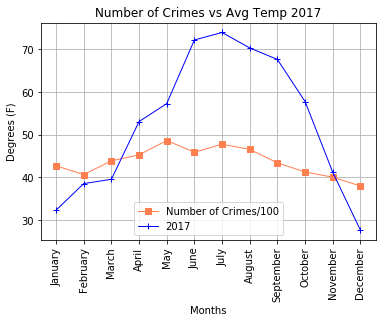

In [49]:
crime_df_17
crime_df_17["Date"] = pd.to_datetime(crime_df_17["Date"])
crime_df_17['Month'] = pd.DatetimeIndex(crime_df_17['Date']).month
crime_group_17 = crime_df_17.groupby(['Month'])
crime_count_17 = crime_group_17["Primary Type"].count()
crime_count_17
crime_yaxe_17 = [(4271/100), (4068/100), (4387/100), (4529/100), (4863/100), (4589/100), (4778/100), (4656/100), (4341/100), (4129/100), (4006/100), (3800/100)]

crime_data, = plt.plot(x_axis, crime_yaxe_17, marker="s", color="coral", linewidth=1, label = "Number of Crimes/100")
weath_17, = plt.plot(x_axis, y_axis_17, marker="+",color="blue", linewidth=1, label="2017")
plt.xticks(x_axis, labels, rotation='vertical')
plt.title("Number of Crimes vs Avg Temp 2017")
plt.xlabel("Months")
plt.ylabel("Degrees (F)")
plt.legend(handles=[crime_data, weath_17], loc="best")

plt.grid()
plt.savefig("Crime_Temp_173.png", bbox_inches = "tight")
plt.show()
#plt.savefig("Crime_Temp_17.png")

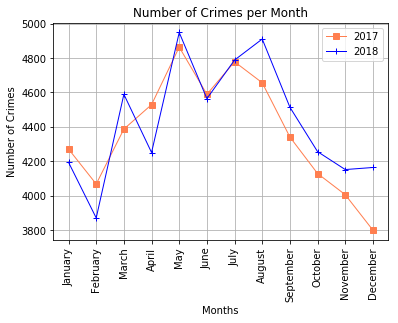

In [48]:
#Average Numbers of Crime 2017 and 2018
count_17 = [4271, 4068, 4387, 4529, 4863, 4589, 4778, 4656, 4341, 4129, 4006, 3800]
count_18 = [4194, 3871, 4589, 4251, 4948, 4564, 4788, 4910, 4514, 4256, 4152, 4164]

crime_17, = plt.plot(x_axis, count_17, marker="s", color="coral", linewidth=1, label = "2017")
crime_18, = plt.plot(x_axis, count_18, marker="+",color="blue", linewidth=1, label="2018")
plt.xticks(x_axis, labels, rotation='vertical')
plt.title("Number of Crimes per Month")
plt.xlabel("Months")
plt.ylabel("Number of Crimes")
plt.legend(handles=[crime_17, crime_18], loc="best")

plt.grid()
plt.savefig("CrimesperMonth3.png" ,bbox_inches = "tight")
plt.show()



In [35]:
#Regression for 2017 weather and crime

weather_17 = np.array([(32.34**2), (38.56**2), (39.57**2), (53.07**2), (57.27**2), (72.15**2), (73.90**2), (70.29**2), (67.59**2), (57.76**2), (41.21**2), (27.67**2)]).reshape(1, -1)
crime_17 = np.array([4271, 4068, 4387, 4529, 4863, 4589, 4778, 4656, 4341, 4129, 4006, 3800]).reshape(1,-1)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(weather_17, crime_17)

R2_Value_17 = r_value**2
R2_Value_17

0.5078554415999353

In [34]:
#Regression for 2018 weather and crime 
weather_18 = np.array([(26.65**2), (30.12**2), (37.02**2), (40.28**2), (64.57**2), (70.13**2), (74.59**2), (74.13**2), (68.77**2), (53.43**2), (35.56**2), (33.61**2)])
crime_18 = np.array([4194, 3871, 4589, 4251, 4948, 4564, 4788, 4910, 4514, 4256, 4152, 4164])

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(weather_18, crime_18)

R2_value_18 = r_value**2
R2_value_18

0.6539057716790152

In [46]:
#Polynomial Regression 
X = [32.34, 38.56, 39.57, 53.07, 57.27, 72.15, 73.90, 70.29, 67.59, 57.76, 41.21, 27.67].array.reshape(-1,1)
y = [4271, 4068, 4387, 4529, 4863, 4589, 4778, 4656, 4341, 4129, 4006, 3800]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

poly_reg = PolynomialFeatures(degree=4)
X_poly = poly_reg.fit_transform(X)
pol_reg = LinearRegression()
pol_reg.fit(X_poly, y)
def viz_polymonial():
    plt.scatter(X, y, color='red')
    plt.plot(X, pol_reg.predict(poly_reg.fit_transform(X)), color='blue')
    plt.title('Truth or Bluff (Linear Regression)')
    plt.xlabel('Position level')
    plt.ylabel('Salary')
    plt.show()
    return
viz_polymonial()

AttributeError: 'list' object has no attribute 'array'

In [ ]:
#Arima Model 
series = [32.34, 38.56, 39.57, 53.07, 57.27, 72.15, 73.90, 70.29, 67.59, 57.76, 41.21, 27.67]
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [31]:
crime_df_18
crime_df_18["Date "]
crime_df_18["Date "] = pd.to_datetime(crime_df_18["Date "])
#crime_df_18 = crime_df_18.rename(columns={'Date': 'Date '})
#Merge Crime 18 and Weather 18 dataframe 
crime_weather = pd.merge(crime_df_18, df_2018, on="Date ", how="inner", suffixes=( "_crime", "_date") )
crime_weather

,ID,Date,IUCR,Primary Type,Description,Location Description,FBI Code,X Coordinate,Y Coordinate,Year_crime,Latitude,Longitude,Month_crime,f_temp,f_temp_min,f_temp_max,weather_description,Month_date,Year_date
0,11222171,2018-02-03 09:00:00,281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,HOSPITAL BUILDING/GROUNDS,2,NaN,NaN,2018,NaN,NaN,2,21.632,19.67,23.27,overcast clouds,2,2018
1,11221908,2018-02-03 09:00:00,330,ROBBERY,AGGRAVATED,CTA STATION,3,1177067.0,1882474.0,2018,41.832848,-87.625810,2,21.632,19.67,23.27,overcast clouds,2,2018
2,11411427,2018-08-12 10:00:00,1562,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,CHURCH/SYNAGOGUE/PLACE OF WORSHIP,17,NaN,NaN,2018,NaN,NaN,8,67.622,62.87,71.87,mist,8,2018
3,11411415,2018-08-12 10:00:00,051A,ASSAULT,AGGRAVATED: HANDGUN,STREET,04A,1168538.0,1856354.0,2018,41.761360,-87.657857,8,67.622,62.87,71.87,mist,8,2018
4,11411434,2018-08-12 10:00:00,1340,CRIMINAL DAMAGE,TO STATE SUP PROP,"SCHOOL, PUBLIC, BUILDING",14,1147025.0,1910941.0,2018,41.911591,-87.735312,8,67.622,62.87,71.87,mist,8,2018
5,11411482,2018-08-12 10:00:00,051A,ASSAULT,AGGRAVATED: HANDGUN,RESIDENCE,04A,1170418.0,1850212.0,2018,41.744465,-87.651145,8,67.622,62.87,71.87,mist,8,2018
6,11616364,2018-10-22 20:00:00,281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,RESIDENCE,2,NaN,NaN,2018,NaN,NaN,10,61.970,61.07,62.87,scattered clouds,10,2018
7,11537270,2018-12-16 17:00:00,460,BATTERY,SIMPLE,SPORTS ARENA/STADIUM,08B,NaN,NaN,2018,NaN,NaN,12,40.352,35.15,45.23,mist,12,2018
8,11537270,2018-12-16 17:00:00,460,BATTERY,SIMPLE,SPORTS ARENA/STADIUM,08B,NaN,NaN,2018,NaN,NaN,12,40.352,35.15,45.23,haze,12,2018
9,11537476,2018-12-16 17:00:00,031A,ROBBERY,ARMED: HANDGUN,ALLEY,3,1170512.0,1846828.0,2018,41.735177,-87.650899,12,40.352,35.15,45.23,mist,12,2018


/Users/scott/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '
/Users/scott/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


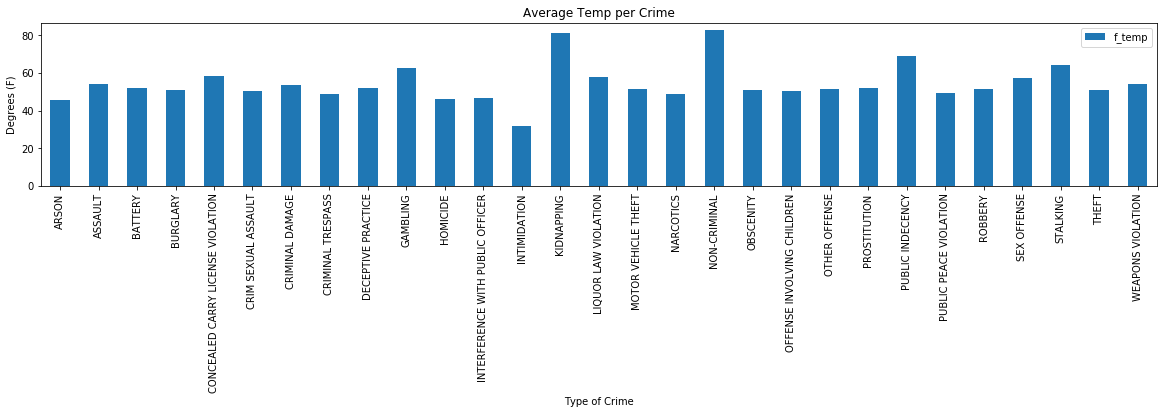

In [47]:
type_group = crime_weather.groupby(["Primary Type"])
crime_by_temp = type_group["f_temp"].mean()

crime_by_temp = crime_by_temp.to_frame()

crime_by_temp.plot(kind="bar", figsize=(20,3))

plt.title("Average Temp per Crime")
plt.ylabel("Degrees (F)")
plt.xlabel("Type of Crime")
plt.tight_layout()
plt.savefig("TempCrimeBar4.png", bbox_inches = "tight")
plt.tight_layout()
plt.show()


Primary Type
ARSON                                   3
ASSAULT                               466
BATTERY                              1923
BURGLARY                              141
CONCEALED CARRY LICENSE VIOLATION       6
CRIM SEXUAL ASSAULT                    66
CRIMINAL DAMAGE                       262
CRIMINAL TRESPASS                     466
DECEPTIVE PRACTICE                    162
GAMBLING                               21
HOMICIDE                               12
INTERFERENCE WITH PUBLIC OFFICER       84
INTIMIDATION                            3
KIDNAPPING                              2
LIQUOR LAW VIOLATION                   24
MOTOR VEHICLE THEFT                   263
NARCOTICS                            1250
NON-CRIMINAL                            1
OBSCENITY                              43
OFFENSE INVOLVING CHILDREN            157
OTHER OFFENSE                         486
PROSTITUTION                           56
PUBLIC INDECENCY                        2
PUBLIC PEACE VIOLATIO